In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from helpers import get_topix_data

#%%
three_factor_data = pd.read_csv('../data/ff_three_factors_analysis.csv')
portfolio_data = pd.read_csv('../data/CCAReturn.csv')

# カラムの制限
three_factor_data = three_factor_data[['Date', 'Alpha']]
portfolio_data = portfolio_data[['MONTH', 'top_25p', 'top_100p']]

portfolio_data['return'] = portfolio_data['top_25p'] - portfolio_data['top_100p']

#%%
three_factor_data['Date'] = pd.to_datetime(three_factor_data['Date'])
portfolio_data['MONTH'] = pd.to_datetime(portfolio_data['MONTH'])

# データの共通期間を取得
start_date = max(three_factor_data['Date'].min(), portfolio_data['MONTH'].min())
end_date = min(three_factor_data['Date'].max(), portfolio_data['MONTH'].max())

# 各データを共通期間でフィルタリング
three_factor_data = three_factor_data[(three_factor_data['Date'] >= start_date) & (three_factor_data['Date'] <= end_date)].reset_index(drop=True)
portfolio_data = portfolio_data[(portfolio_data['MONTH'] >= start_date) & (portfolio_data['MONTH'] <= end_date)].reset_index(drop=True)

# データの期間確認
print("three_factor_data期間:", three_factor_data['Date'].min().strftime('%Y-%m'), "〜", three_factor_data['Date'].max().strftime('%Y-%m'))
print("portfolio_data期間:", portfolio_data['MONTH'].min().strftime('%Y-%m'), "〜", portfolio_data['MONTH'].max().strftime('%Y-%m'))

#%%
# three_factor_dataとportfolio_dataを日付で結合
merged_data = pd.merge(
    three_factor_data, 
    portfolio_data, 
    left_on='Date', 
    right_on='MONTH', 
    how='inner'
)
# データフレームの先頭を表示
print(merged_data.head())

#%%
# top_25p - topix_returnと、alphaをグラフで比較
# 必要なカラムを抽出
plot_df = merged_data[['Date', 'Alpha', 'return']].copy()

three_factor_data期間: 2022-01 〜 2024-08
portfolio_data期間: 2022-01 〜 2024-08
        Date     Alpha      MONTH   top_25p  top_100p    return
0 2022-01-01  0.005382 2022-01-01 -0.072512 -0.064089 -0.008422
1 2022-02-01  0.008263 2022-02-01  0.039363  0.028553  0.010810
2 2022-03-01  0.006874 2022-03-01  0.026638  0.016640  0.009999
3 2022-04-01  0.007239 2022-04-01 -0.006982 -0.021676  0.014694
4 2022-05-01  0.005654 2022-05-01  0.012878  0.002440  0.010438


In [8]:
# Top25%銘柄リスト（例: columns=['MONTH', 'TICKER']）
top25_df = pd.read_csv('../data/top25_tickers.csv')
top25_df['DATE'] = pd.to_datetime(top25_df['MONTH'])

price_data = pd.read_csv('../../DATAHUB/Price_Data/price_data_for_cca.csv')
price_data['DATE'] = pd.to_datetime(price_data['DATE'])  # ← ここを追加

price_data

,DATE,TICKER,PRICE,DIVIDENDS,MONTHLY_RETURN
0,2013-01-01,2138,923.174316,0.0,NaN
1,2013-02-01,2138,1558.038574,0.0,0.687697
2,2013-03-01,2138,1587.160767,15.0,0.028319
3,2013-04-01,2138,1977.104126,0.0,0.245686
4,2013-05-01,2138,3473.158691,0.0,0.756690
...,...,...,...,...,...
30499,2025-02-01,5032,2811.156250,0.0,-0.110972
30500,2025-03-01,5032,3201.704834,0.0,0.138928
30501,2025-04-01,5032,3667.587646,32.5,0.155662
30502,2025-05-01,5032,3950.000000,0.0,0.077002


In [9]:
#%% Top25%銘柄の月次リターンをマージ
merged = pd.merge(top25_df, price_data, on=['DATE', 'TICKER'], how='left')

mean_return = merged.groupby('MONTH')['MONTHLY_RETURN'].mean()
mean_return_idx = list(mean_return.index)

mean_return

MONTH
2014-01   -0.051265
2014-02   -0.012435
2014-03    0.041784
2014-04    0.000418
2014-05    0.036229
             ...   
2025-02   -0.031332
2025-03    0.018905
2025-04    0.052409
2025-05    0.015219
2025-06    0.008656
Name: MONTHLY_RETURN, Length: 138, dtype: float64

In [10]:
#%% 2. 各月のリターン分布統計量
stats = merged.groupby('MONTH')['MONTHLY_RETURN'].agg(
    mean='mean', std='std', min='min', max='max', median='median',
    q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
stats = pd.DataFrame(stats)
stats['iqr'] = stats['q75'] - stats['q25']
stats_idx = list(stats.index)

In [11]:
turnover = []
prev_set = set()
for month, group in top25_df.groupby('MONTH'):
    curr_set = set(group['TICKER'])
    if prev_set:
        new_tickers = curr_set - prev_set
        turnover_rate = len(new_tickers) / len(curr_set) if len(curr_set) > 0 else np.nan
    else:
        turnover_rate = np.nan  # 初月は計算不可
    turnover.append({'MONTH': month, 'turnover_rate': turnover_rate})
    prev_set = curr_set
turnover_df = pd.DataFrame(turnover).set_index('MONTH')
turnover_idx = list(turnover_df.index)


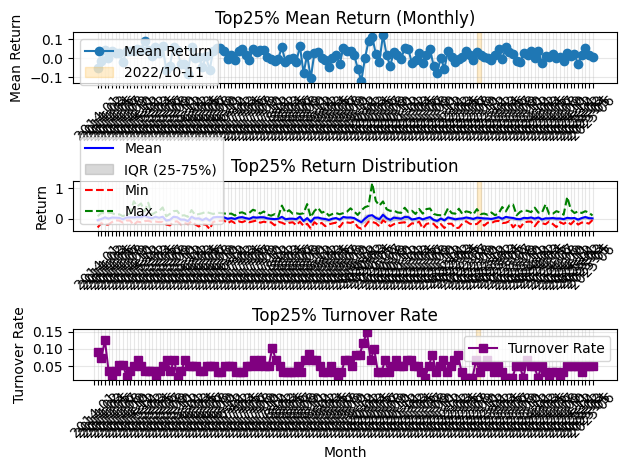

In [12]:
# まず、インデックスがDatetimeIndexであることを確認し、なければ変換
def get_index_of_date(idx, date_str):
    date = pd.to_datetime(date_str)
    # idxがDatetimeIndexでなければ変換
    if not isinstance(idx, pd.DatetimeIndex):
        idx = pd.to_datetime(idx)
    # dateが存在するか確認
    if date in idx:
        return idx.get_loc(date)
    else:
        print(f"警告: {date_str} はインデックスに存在しません。")
        return None

highlight_start = get_index_of_date(mean_return.index, '2022-10-01')
highlight_end = get_index_of_date(mean_return.index, '2022-11-01')

# highlight_start, highlight_endがNoneでなければ描画を続行
if highlight_start is not None and highlight_end is not None:
    # 平均リターン
    plt.subplot(3, 1, 1)
    plt.plot(mean_idx, mean_return.values, marker='o', label='Mean Return')
    plt.axvspan(highlight_start, highlight_end, color='orange', alpha=0.2, label='2022/10-11')
    plt.title('Top25% Mean Return (Monthly)')
    plt.ylabel('Mean Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(mean_idx, [d.strftime('%Y-%m') if hasattr(d, 'strftime') else str(d) for d in mean_return.index], rotation=45)

    # 分布統計量
    plt.subplot(3, 1, 2)
    plt.plot(stats_idx, stats['mean'], label='Mean', color='blue')
    plt.fill_between(stats_idx, stats['q25'], stats['q75'], color='gray', alpha=0.3, label='IQR (25-75%)')
    plt.plot(stats_idx, stats['min'], linestyle='--', color='red', label='Min')
    plt.plot(stats_idx, stats['max'], linestyle='--', color='green', label='Max')
    plt.axvspan(highlight_start, highlight_end, color='orange', alpha=0.2)
    plt.title('Top25% Return Distribution')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(stats_idx, [d.strftime('%Y-%m') if hasattr(d, 'strftime') else str(d) for d in stats.index], rotation=45)

    # ターンオーバー率
    plt.subplot(3, 1, 3)
    plt.plot(turnover_idx, turnover_df['turnover_rate'], marker='s', color='purple', label='Turnover Rate')
    plt.axvspan(highlight_start, highlight_end, color='orange', alpha=0.2)
    plt.title('Top25% Turnover Rate')
    plt.ylabel('Turnover Rate')
    plt.xlabel('Month')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(turnover_idx, [d.strftime('%Y-%m') if hasattr(d, 'strftime') else str(d) for d in turnover_df.index], rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("指定した期間（2022-10, 2022-11）がインデックスに存在しないため、ハイライト表示をスキップします。")


In [13]:
focus_period = (merged['MONTH'] >= '2022-10-01') & (merged['MONTH'] <= '2022-11-30')
print('=== 2022年10月〜11月 Top25%銘柄リターン分布 ===')
print(merged[focus_period].groupby('MONTH')['RETURN'].describe())

print('=== 2022年10月〜11月 ターンオーバー率 ===')
print(turnover_df.loc['2022-10-01':'2022-11-30'])


=== 2022年10月〜11月 Top25%銘柄リターン分布 ===


KeyError: 'Column not found: RETURN'